## Twitter Sentimental Analysis - Cyberbullying

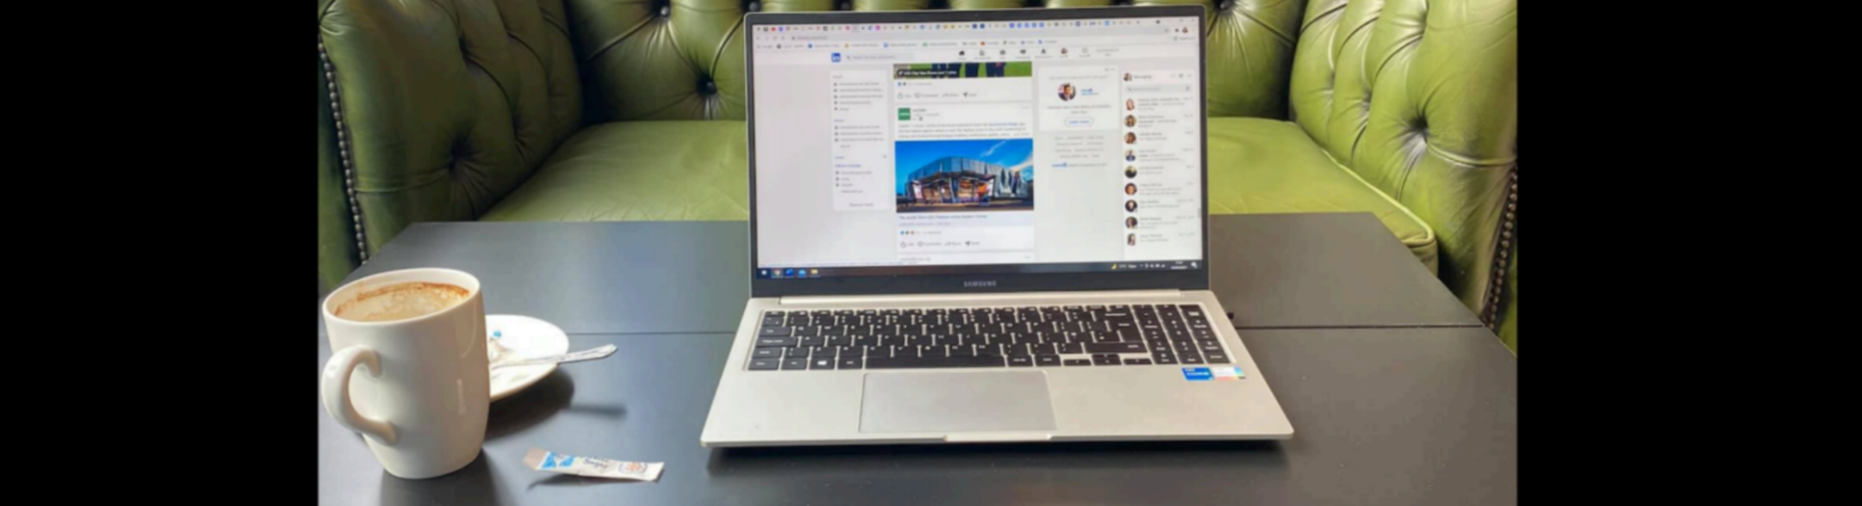

### Hemant Thapa

#### Import Libraries 

In [1]:
import io
import re
import nltk
import emoji
import string
import pickle
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
importlib.reload(string)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from tabulate import tabulate
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Attention
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

2024-02-07 20:16:36.198224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harryworlds/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harryworlds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Loading DataSet 

In [4]:
# loading csv file
tweets_df  = pd.read_csv('cyberbullying_tweets.csv')

In [5]:
# renaming columns name
tweets_df .rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'}, inplace=True)
# removing duplicate rows 
tweets_df .drop_duplicates(subset="text", inplace=True)

In [6]:
# top five rows
tweets_df [:5]

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [7]:
# bottom five columns 
tweets_df.tail()

,text,sentiment
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [8]:
#checking information of columns 
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46017 non-null  object
 1   sentiment  46017 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


We have two categorical columns, text and sentiments. The text column represents user comments, while the sentiments column represents user emotions and behaviors.

In [9]:
#shape of rows and columns of our dataset
tweets_df.shape

(46017, 2)

we have nearly, 46017 rows and 2 columns in our dataframe.

In [10]:
# size of dataframe row and columns 
tweets_df.size

92034

if we multiply rows and columns, we have nearly 92034 data points.

In [11]:
# counting values of sentiment columns 
tweets_df.sentiment.value_counts()

sentiment
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

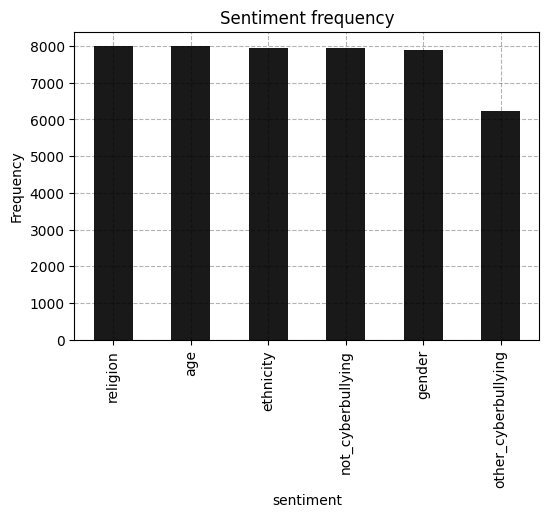

In [12]:
# counting values of sentiment columns 
plt.figure(figsize=(6,4))
tweets_df.sentiment.value_counts().plot(kind='bar', color='black', alpha=0.9)
plt.ylabel("Frequency")
plt.title('Sentiment frequency')
plt.grid(True, ls='--', alpha=0.3, color='black')
plt.show()

- Religion: 7995 occurrences
- Age: 7992 occurrences
- Ethnicity: 7952 occurrences
- Not Cyberbullying: 7937 occurrences
- Gender: 7898 occurrences
- Other Cyberbullying: 6243 occurrences

In [13]:
# statical analysis of values in sentiment columns 
tweets_df.sentiment.value_counts().describe()

count       6.000000
mean     7669.500000
std       699.776179
min      6243.000000
25%      7907.750000
50%      7944.500000
75%      7982.000000
max      7995.000000
Name: count, dtype: float64

In [14]:
# first 20 comments
for i in range(20):
    print(tweets_df['text'][i])

In other words #katandandre, your food was crapilicious! #mkr
Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
@XochitlSuckkks a classy whore? Or more red velvet cupcakes?
@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
@stockputout everything but mostly my priest
Rebecca Black Drops Out of School Due to Bullying:
@Jord_Is_Dead http://t.co/UsQInYW5Gn
The Bully flushes on KD http://twitvid.com/A2TNP
Ughhhh #MKR
RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##Googl

In [15]:
# bottom 20 comments
total_rows = len(tweets_df)
for i in range(total_rows - 20, total_rows):
    print(tweets_df['text'][i])

Going to ride wid my chopper friend dem!! Fuck u broke niggers an dumb bitchs skrr skrr u c me onda blocka!!
DRINK CUM AND EAT POOP YOU BITCH ASS FAGGOT FUCKING NIGGER WHITE POWER DUMB NIGGERS WHITE POWER RULES OVER YOU ALL BOW THE FUCK DOWN
Shut the fuck up, Red, you dumb nigger.
RT @tayyoung_ FUCK OBAMA, dumb ass nigger &lt;&lt;&lt;&lt;She mad llf. #4MoreYears
@Blind_Brian Haha Holy fuck. You're a dumb nigger. You would see me at the arcade hoops game.
Fuck these dumb niggers in here
The pure hatred some of you niggers have for black women is disgusting. Like truly seek help.
Did you ever had a friend that say's doo you want a cheese burger whit cheese.somtimes he's a dumb fuck butt stil my nigger
The black lady is freaking out cuz she's prego by a guy who wears a cupcake belt n think his gay what the fuck dumb nigger lady
Fuck a nigger with a nigger that fucks with dumb broke niggas #broke#niggers#stay#broke#don't#fuck#with#emm
Disgusting "@Shelly_Smyth: I hope nigger Obama loses th

In [16]:
# total missing values
tweets_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [17]:
# # encoding sentiment in digits
# tweets_df["encode"] = tweets_df["sentiment"].replace({"religion": 1, 
#                                                     "age": 2, 
#                                                     "ethnicity": 3,
#                                                     "gender": 4, 
#                                                     "other_cyberbullying": 5,
#                                                     "not_cyberbullying": 6})

In [18]:
sentiment_to_encode = {
    "religion": 1, 
    "age": 2, 
    "ethnicity": 3,
    "gender": 4, 
    "other_cyberbullying": 5,
    "not_cyberbullying": 6
}
tweets_df['encode'] = tweets_df['sentiment'].map(sentiment_to_encode)

In [19]:
# checking encoded columns 
tweets_df[:5]

,text,sentiment,encode
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [20]:
# importing unicode_range.py file and list 
from unicode_range import unicode_range

In [21]:
# contractions dictionary
contractions_dict = {
    "can't": "cannot",
    "can\'t": "cannot",
    "n't": " not",
    "n\'t": " not",
    "'re": " are",
    "’re": " are",
    "'s": " is",
    "’s": " is",
    "'d": " would",
    "’d": " would",
    "'ll": " will",
    "’ll": " will",
    "'t": " not",
    "’t": " not",
    "'ve": " have",
    "’ve": " have",
    "'m": " am",
    "’m": " am",
    "I'm": "I am",
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "cannot": "can not",
    "could've": "could have",
    "might've": "might have",
    "must've": "must have",
    "should've": "should have",
    "would've": "would have",
}

In [22]:
def preprocess_text(text):
    # function to remove emojis
    def remove_emoji(text, unicode_ranges):
        emoji_pattern = re.compile(f"[{''.join(unicode_ranges)}]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # function to expand contractions
    def expand_contractions(text, contractions_dict):
        contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

        def replace(match):
            return contractions_dict[match.group(0)]

        return contractions_re.sub(replace, text)

    # F=function to remove multiple consecutive spaces
    def remove_mult_spaces(text):
        return re.sub(r'\s+', ' ', text).strip()

    # function to remove symbols, hashtags, and punctuation
    def removing_symbols(text):
        text_without_hashtags = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
        text_without_underscores = " ".join(word.strip() for word in re.split('#|_', text_without_hashtags))
        cleaned_text = re.sub(r'[!?]', '', text_without_underscores)
        return cleaned_text

    # function to filter out words containing '$' or '&'
    def filter_char(text):
        filtered_words = [word for word in text.split() if '$' not in word and '&' not in word]
        return ' '.join(filtered_words)

    # remove emojis
    text = remove_emoji(text, unicode_range)
    # expand contractions
    text = expand_contractions(text, contractions_dict)
    # normalise whitespace and lowercase the text
    text = text.replace('\r', '').replace('\n', ' ').lower()
    # remove URLs, non-ASCII characters, and numbers
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    non_ascii_pattern = re.compile(r'[^\x00-\x7f]')
    number_pattern = re.compile(r'[0-9]+')
    text = url_pattern.sub('', text)
    text = non_ascii_pattern.sub('', text)
    text = number_pattern.sub('', text)
    # remove punctuation using translate
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove symbols, hashtags, and punctuation
    text = removing_symbols(text)
    # filter out words containing '$' or '&'
    text = filter_char(text)
    # remove multiple consecutive spaces
    text = remove_mult_spaces(text)

    return text

In [23]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess_text)

In [24]:
# first 20 comments
for i in range(20):
    print(tweets_df['cleaned_text'][i])

in other words katandandre your food was crapilicious mkr
why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc
xochitlsuckkks a classy whore or more red velvet cupcakes
jasongio meh p thanks for the heads up but not too concerned about another angry dude on twitter
rudhoeenglish this is an isis account pretending to be a kurdish account like islam it is all lies
rajaaab quickieleaks yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence
itu sekolah ya bukan tempat bully ga jauh kaya neraka
karma i hope it bites kat on the butt she is just nasty mkr
stockputout everything but mostly my priest
rebecca black drops out of school due to bullying
jordisdead
the bully flushes on kd
ughhhh mkr
rt kurdsnews turkish state has killed children in last years news googleeviricitopluluukrteyidee
love that the best response to the hotcakes they managed to film was a noncommittal meh from some adolescent

In [25]:
# tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(tweets_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [26]:
# word index
word_index = tokenizer.word_index

In [27]:
train_texts, test_texts, train_labels, test_labels = train_test_split( tweets_df['cleaned_text'], 
                                                                       tweets_df['encode'], 
                                                                       test_size=0.3, 
                                                                       random_state=0
                                                                    )

In [28]:
(train_texts.shape, train_labels.shape), (test_texts.shape, test_labels.shape)

(((32211,), (32211,)), ((13806,), (13806,)))

In [29]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(train_texts)

# texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# pad the sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=100)  
test_padded = pad_sequences(test_sequences, maxlen=100)


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=100),  
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 160558 (627.18 KB)
Trainable params: 160558 (627.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
train_labels = train_labels - 1
test_labels = test_labels - 1

In [33]:
history = model.fit(train_padded, train_labels, epochs=20, batch_size=32, validation_data=(test_padded, test_labels))

Epoch 1/20
1007/1007 [==============================] - 5s 4ms/step - loss: 1.2910 - accuracy: 0.5331 - val_loss: 0.6734 - val_accuracy: 0.7650
Epoch 2/20
1007/1007 [==============================] - 5s 5ms/step - loss: 0.5342 - accuracy: 0.7863 - val_loss: 0.4737 - val_accuracy: 0.8007
Epoch 3/20
1007/1007 [==============================] - 4s 4ms/step - loss: 0.4329 - accuracy: 0.8071 - val_loss: 0.4357 - val_accuracy: 0.8060
Epoch 4/20
1007/1007 [==============================] - 4s 4ms/step - loss: 0.3913 - accuracy: 0.8251 - val_loss: 0.4161 - val_accuracy: 0.8143
Epoch 5/20
1007/1007 [==============================] - 4s 4ms/step - loss: 0.3616 - accuracy: 0.8400 - val_loss: 0.3990 - val_accuracy: 0.8227
Epoch 6/20
1007/1007 [==============================] - 4s 4ms/step - loss: 0.3355 - accuracy: 0.8562 - val_loss: 0.4001 - val_accuracy: 0.8249
Epoch 7/20
1007/1007 [==============================] - 4s 4ms/step - loss: 0.3140 - accuracy: 0.8701 - val_loss: 0.3914 - val_accuracy:

In [34]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test Accuracy:', test_acc)

432/432 [==============================] - 2s 3ms/step - loss: 0.5052 - accuracy: 0.8298
Test Accuracy: 0.8297841548919678


In [35]:
y_pred = model.predict(test_padded)

432/432 [==============================] - 1s 1ms/step


In [36]:
y_pred[:1]

array([[9.9998957e-01, 3.2281071e-06, 2.3491025e-06, 3.7716527e-12,
        3.8768549e-06, 8.8949974e-07]], dtype=float32)

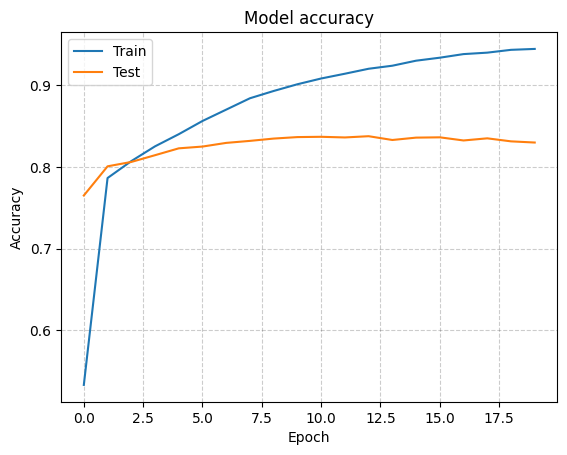

In [37]:
# training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

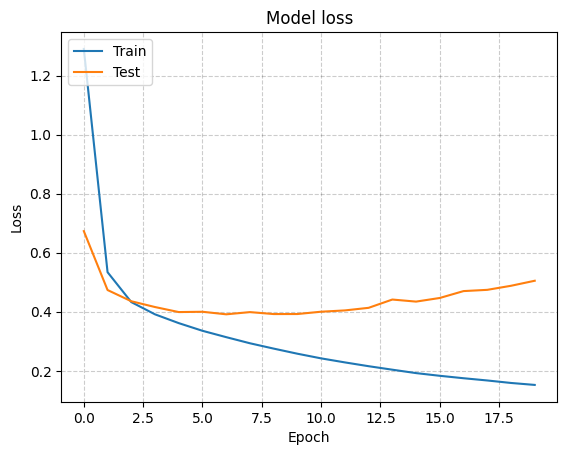

In [38]:
# training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
#inversing word index
reverse_word_index = {}
for key, value in word_index.items():
    reverse_word_index[value] = key

In [40]:
#decoding sentence
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [41]:
#vocab_size, embedding_dim
e = model.layers[0]
weights = e.get_weights()[0]

In [42]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [43]:
sentence = ["Hello, Thank you so much for your help"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
predictions = model.predict(padded)

1/1 [==============================] - 0s 21ms/step


In [44]:
np.set_printoptions(suppress=True)
print(predictions)

[[0.00023967 0.00006814 0.00102727 0.01995623 0.20082213 0.77788645]]


In [45]:
sentiment_encoding = {
    1: "Religion",
    2: "Age",
    3: "Ethnicity",
    4: "Gender",
    5: "Other Cyberbullying",
    6: "Not Cyberbullying"
}

In [46]:
predicted_classes = np.argmax(predictions, axis=1) + 1 

In [47]:
predicted_labels = [sentiment_encoding[class_index] for class_index in predicted_classes]
predicted_labels

['Not Cyberbullying']

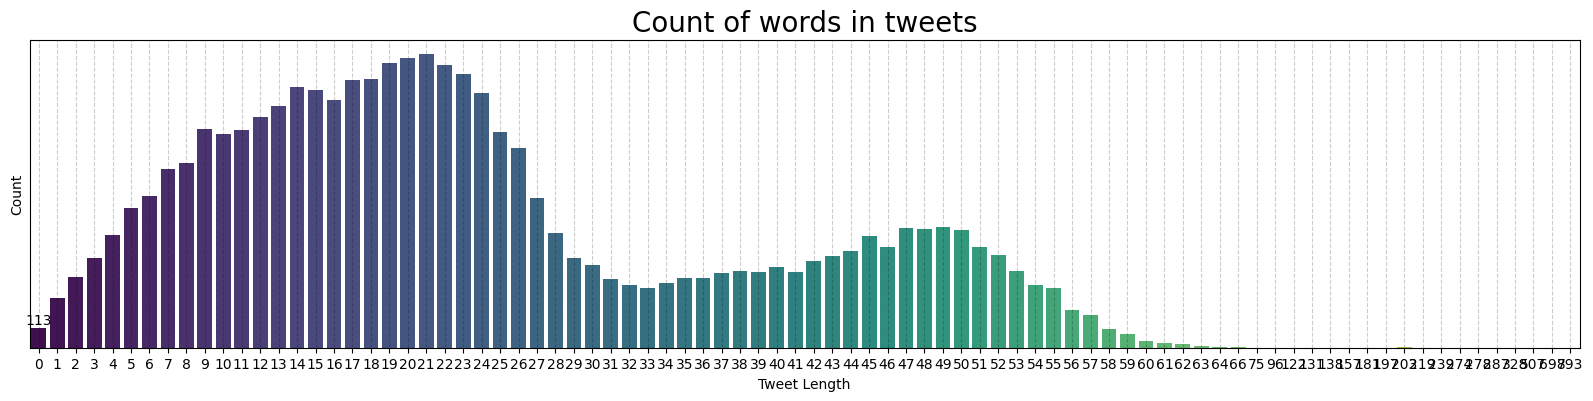

In [48]:
# length of each preprocessed tweet
text_len = [len(text.split()) for text in tweets_df['cleaned_text']]  
tweets_df['text_len'] = text_len

plt.figure(figsize=(20,4))
ax = sns.countplot(x='text_len', data=tweets_df, palette='viridis')
plt.title('Count of words in tweets', fontsize=20)
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Tweet Length')
plt.show()

In [49]:
def plot_wordcloud(cyberbullying_type, dataframe):
    string = " ".join(dataframe[dataframe['sentiment'] == cyberbullying_type]['cleaned_text'].values)
    wordcloud = WordCloud(background_color='white', max_words=2000, max_font_size=256, random_state=42, min_font_size=10,).generate(string)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(cyberbullying_type)
    plt.show()

In [50]:
not_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'not_cyberbullying']
gender_type = tweets_df[tweets_df['sentiment'] == 'gender']
religion_type = tweets_df[tweets_df['sentiment'] == 'religion']
other_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'other_cyberbullying']
age_type = tweets_df[tweets_df['sentiment'] == 'age']
ethnicity_type = tweets_df[tweets_df['sentiment'] == 'ethnicity']

In [51]:
def analyse_sentiment_category(sentiment_category, tweets_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # wordCloud for the sentiment 
    generate_wordcloud(sentiment_category, tweets_df, ax1)
    # top 20 words in the sentiment category
    sentiment_data = tweets_df[tweets_df['sentiment'] == sentiment_category]
    top20_words = Counter([word for text in sentiment_data['cleaned_text'] for word in text.split()]).most_common(20)
    top20_words_df = pd.DataFrame(top20_words, columns=['Top Words', 'Count'])
    #top 20 words 
    sns.barplot(data=top20_words_df, x='Count', y='Top Words', palette='viridis', ax=ax2)
    ax2.set_title(f"Top 20 Words in '{sentiment_category}' Cyberbullying")
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Top Words')
    plt.grid(True, ls='--', alpha=0.3, color='gray')
    plt.tight_layout()
    plt.show()
    print("\n")

# function to generate WordCloud
def generate_wordcloud(sentiment_category, tweets_df, ax):
    string = ""
    for i in tweets_df[tweets_df.sentiment == sentiment_category].cleaned_text.values:
        string = string + " " + i.strip()
    wordcloud = WordCloud(background_color ='white', max_words=2000, max_font_size=256,
               random_state=42, width=800, height=400, min_font_size=10).generate(string)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(sentiment_category)

#### Ploting word Cloud and Top Count 

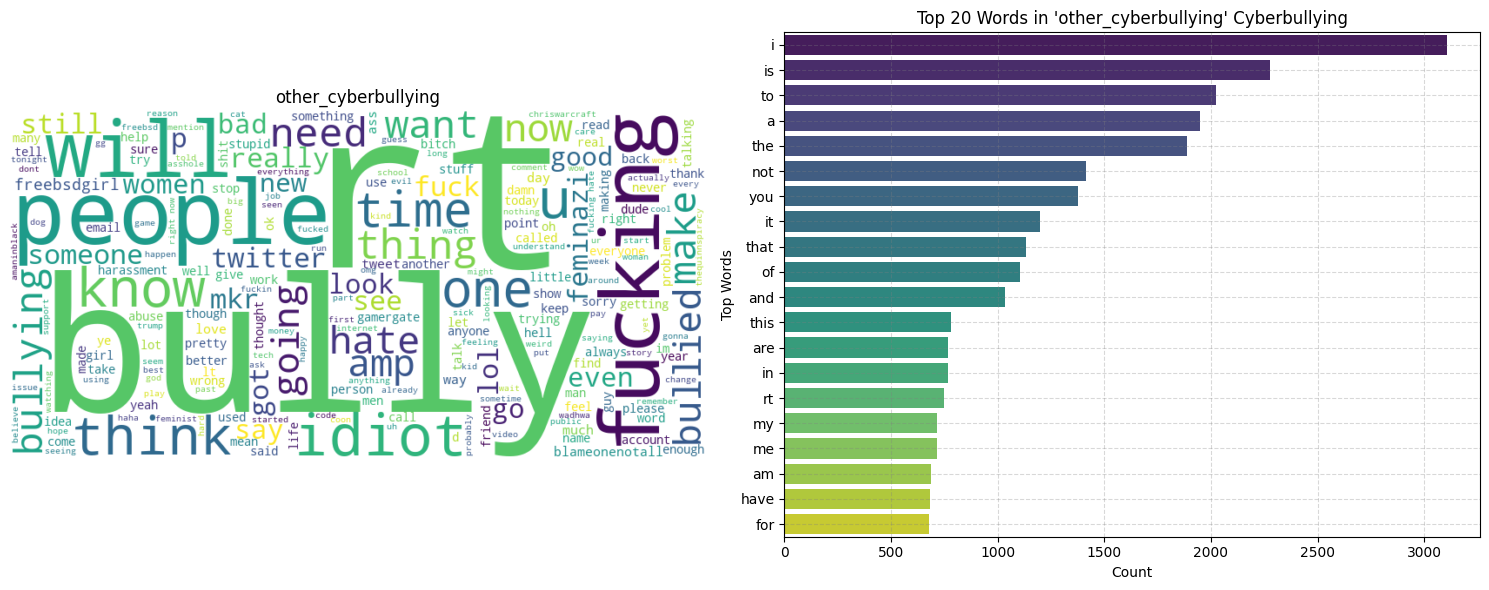

In [52]:
analyse_sentiment_category('other_cyberbullying', tweets_df)

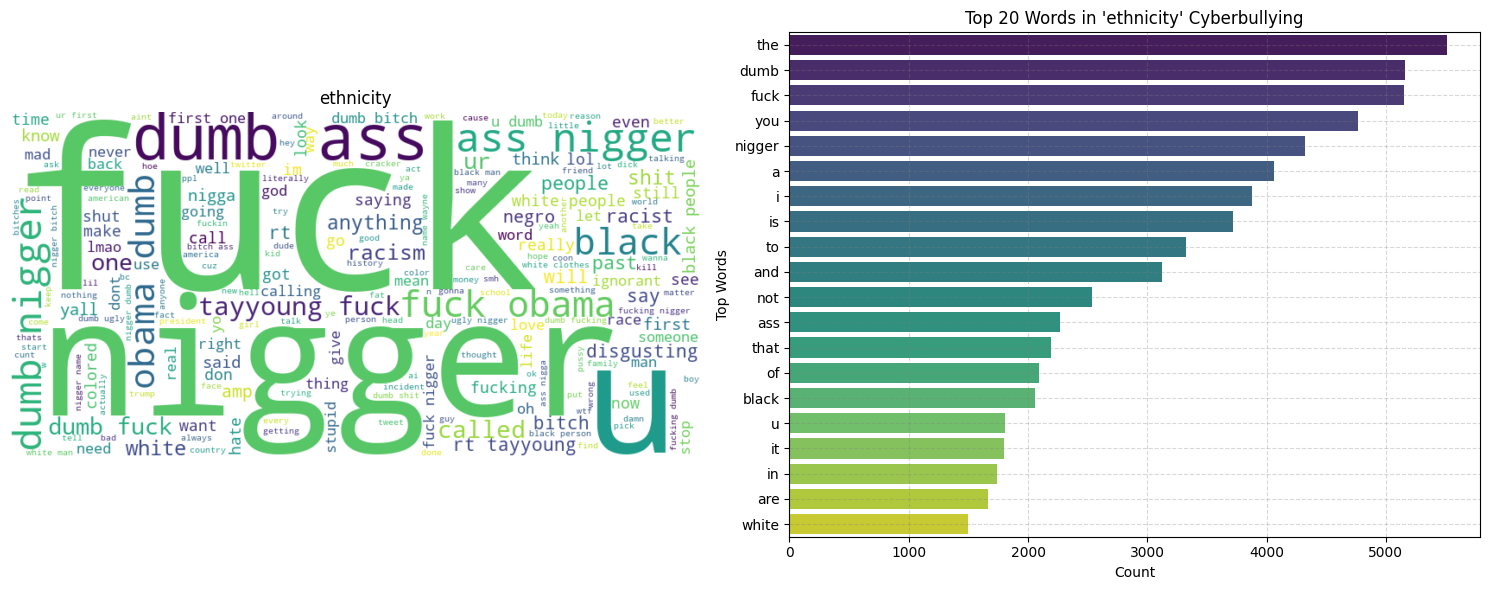

In [53]:
analyse_sentiment_category('ethnicity', tweets_df)

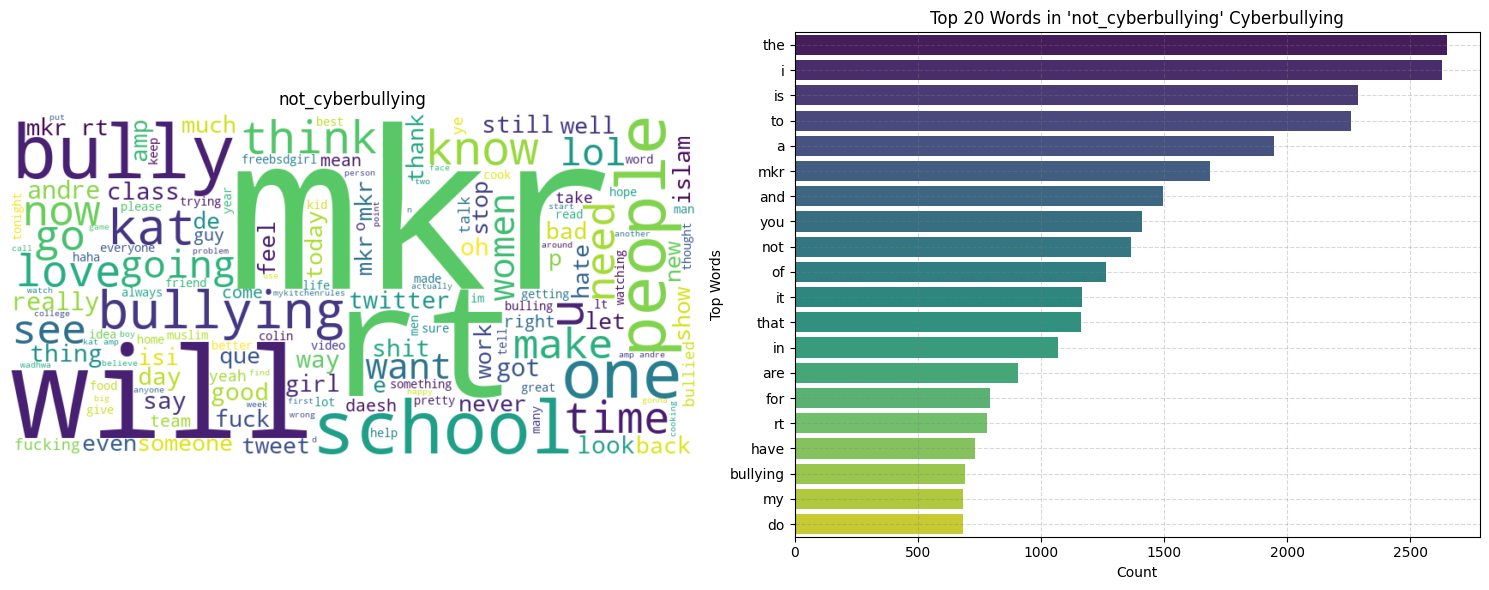

In [54]:
analyse_sentiment_category('not_cyberbullying', tweets_df)

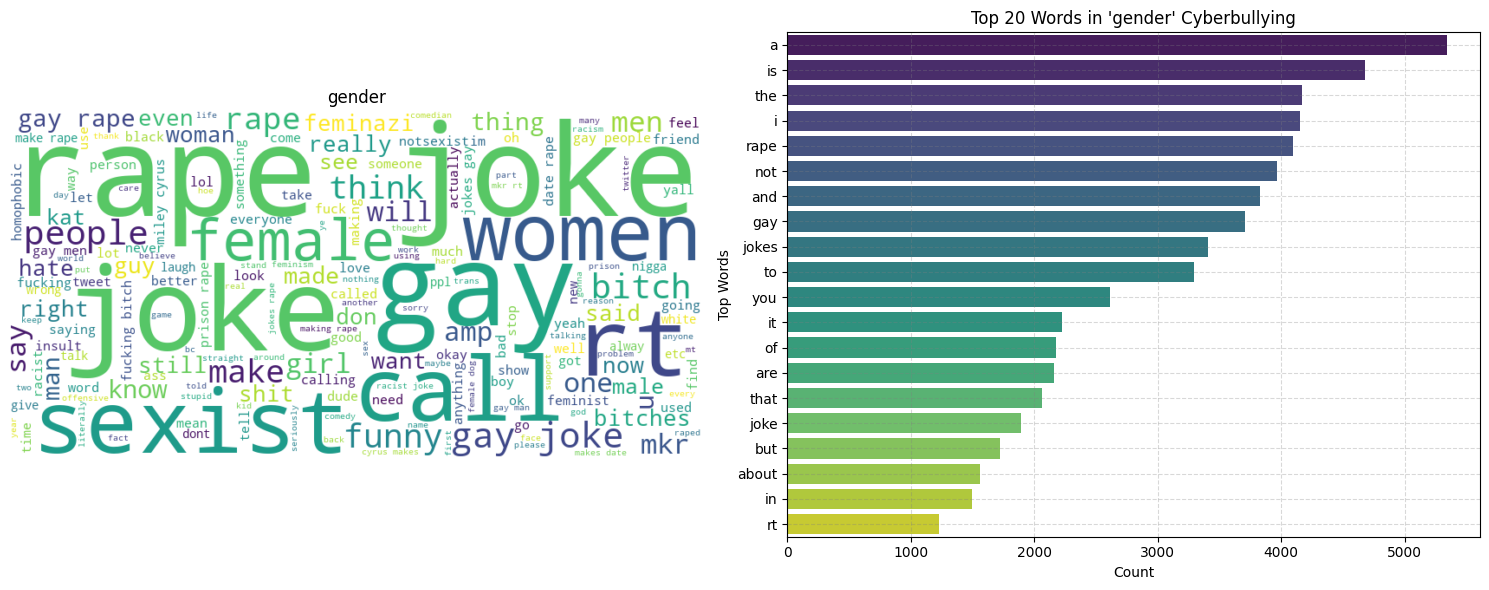

In [55]:
analyse_sentiment_category('gender', tweets_df)

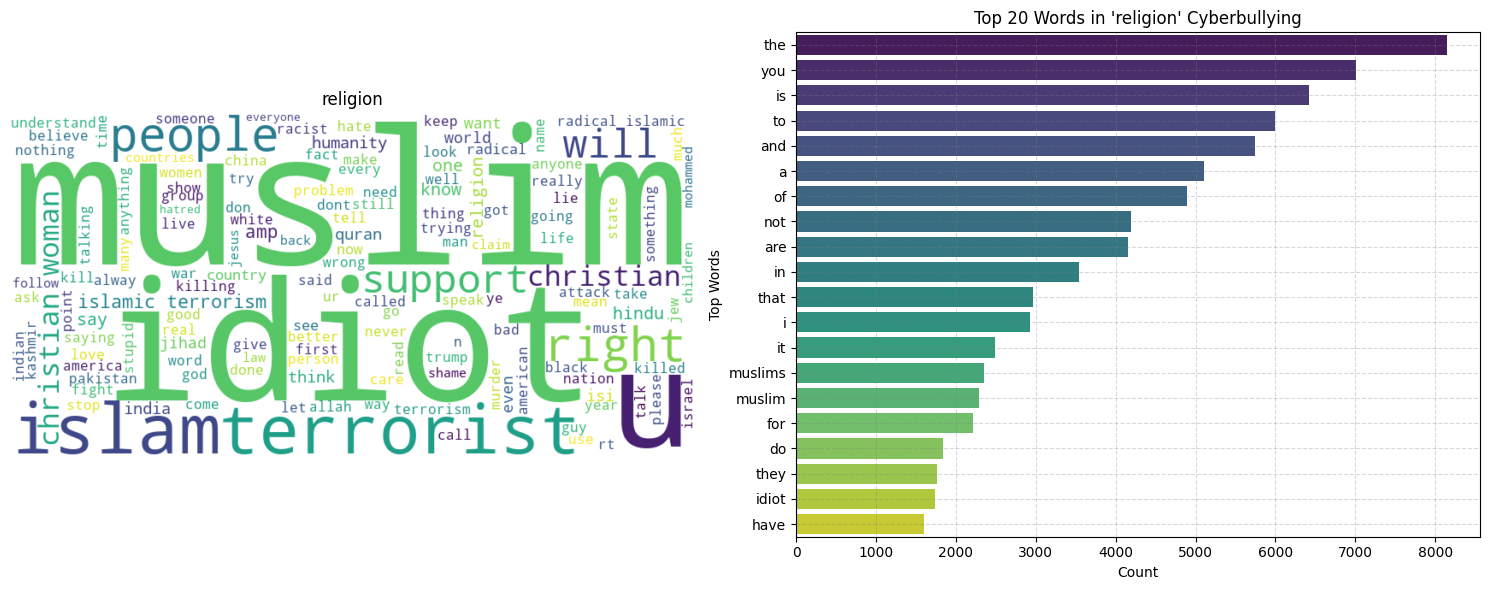

In [56]:
analyse_sentiment_category('religion', tweets_df)

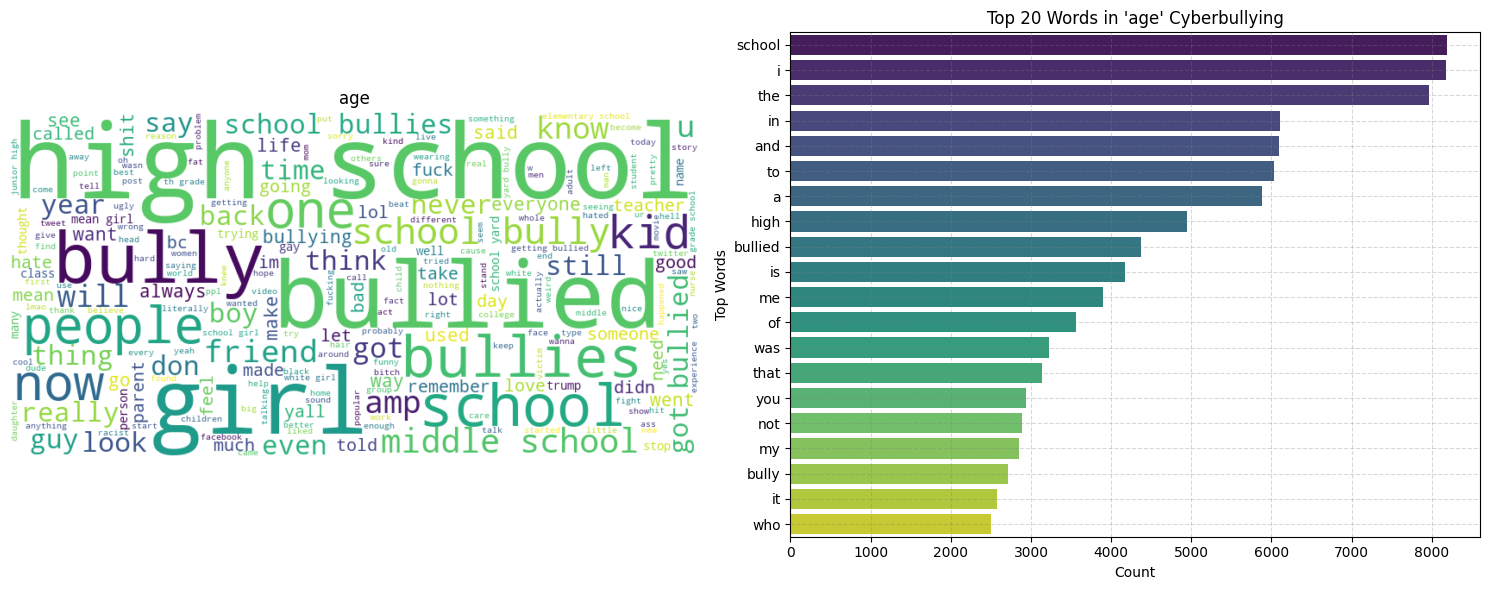

In [57]:
analyse_sentiment_category('age', tweets_df)

#### Let use random text file to classify these sentiments 

In [58]:
# encoding into sentiment 
sentiment_to_encode = {
    "religion": 1, 
    "age": 2, 
    "ethnicity": 3,
    "gender": 4, 
    "other_cyberbullying": 5,
    "not_cyberbullying": 6
}

In [59]:
tweets_df[:5]

,text,sentiment,encode,cleaned_text,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,in other words katandandre your food was crapi...,9
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,why is aussietv so white mkr theblock imaceleb...,14
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,xochitlsuckkks a classy whore or more red velv...,9
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,jasongio meh p thanks for the heads up but not...,18
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,rudhoeenglish this is an isis account pretendi...,18


In [60]:
# checking unique sentiments 
tweets_df['sentiment'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

#### Cyber bullying - Age

In [61]:
# creating age object
age = tweets_df[tweets_df['sentiment'] == 'age']
print(age['cleaned_text'][:3])

31739    here at home neighbors pick on my family and i...
31740    being bullied at school highachieving boys use...
31741    there was a girl in my class in th grade who w...
Name: cleaned_text, dtype: object


In [62]:
age_sentiment = tweets_df.loc[31740, 'cleaned_text']
print(age_sentiment)

being bullied at school highachieving boys use further strategies to maintain masculinity for example becoming bullies themselves disrupting the lessons or devaluing girls achievements


#### Cyber bullying - Gender

In [63]:
# creating gender object
gender = tweets_df[tweets_df['sentiment'] == 'gender']
print(gender['cleaned_text'][:3])

7945    rape is realzvasiyana nema jokes about being d...
7946    you never saw any celebrity say anything like ...
7947    manhattaknight i mean he is gay but he uses ge...
Name: cleaned_text, dtype: object


In [64]:
gender_sentiment = tweets_df.loc[7945, 'cleaned_text']
print(gender_sentiment)

rape is realzvasiyana nema jokes about being drunk or being gay or being lesbianrape is not ones choice or wishthtz where the sensitivity is coming from


#### Cyber bullying - Religion 

In [65]:
# creating religion object
religion = tweets_df[tweets_df['sentiment'] == 'religion']
print(religion['cleaned_text'][:3])

15918    sudeep did she invite him though no right why ...
15919    discerningmumin islam has never been a resista...
15920    boy your comment about journalists wanting to ...
Name: cleaned_text, dtype: object


In [66]:
religion_sentiment = tweets_df.loc[15919, 'cleaned_text']
print(religion_sentiment)

discerningmumin islam has never been a resistance to oppression it has always been source of oppression to both believers and non believer


#### Cyber bullying - Ethnicity 

In [67]:
# creating ethnicity object
ethnicity = tweets_df[tweets_df['sentiment'] == 'ethnicity']
print(ethnicity['cleaned_text'][:3])

39731    hey dumb fuck celebs stop doing something for ...
39732    fuck u bitch rt tayyoung fuck obama dumb ass n...
39733    joebiden no joe you are the racist they have s...
Name: cleaned_text, dtype: object


In [68]:
ethnicity_sentiment = tweets_df.loc[39731, 'cleaned_text']
print(ethnicity_sentiment)

hey dumb fuck celebs stop doing something for people for publicity on facebook wtf happen to life u niggers are cowards


#### Other Cyber bullying 

In [69]:
# creating other cyberbullying object
other_cyberbullying = tweets_df[tweets_df['sentiment'] == 'other_cyberbullying']
print(other_cyberbullying['cleaned_text'][:3])

23916    ikralla fyi it looks like i was caught by it i...
23918    rmaed my monoprice shoddy power bricks on thos...
23921    krainboltgreene did not mention your name i ca...
Name: cleaned_text, dtype: object


In [70]:
other_cyberbullying_sentiment = tweets_df.loc[23918, 'cleaned_text']
print(other_cyberbullying_sentiment)

rmaed my monoprice shoddy power bricks on those getting a refund and picking up another asus vghe it is cheaper anyways


#### Not bullying 

In [71]:
# creating not cyberbullying object
not_cyberbullying = tweets_df[tweets_df['sentiment'] == 'not_cyberbullying']
print(not_cyberbullying['cleaned_text'][:3])

0    in other words katandandre your food was crapi...
1    why is aussietv so white mkr theblock imaceleb...
2    xochitlsuckkks a classy whore or more red velv...
Name: cleaned_text, dtype: object


In [72]:
not_cyberbullying_sentiment = tweets_df.loc[0, 'cleaned_text']
print(not_cyberbullying_sentiment)

in other words katandandre your food was crapilicious mkr


#### Creating dictonary for test sentence with key and values. 

In [73]:
# creating dictonary to store above sentiments
test_sentences = {
    "religion": religion_sentiment,
    "age": age_sentiment,
    "ethnicity": ethnicity_sentiment,
    "gender": gender_sentiment,
    "other_cyberbullying": other_cyberbullying_sentiment,
    "not_cyberbullying": not_cyberbullying_sentiment
}

#### Making predictions. 

In [74]:
# for loop to iterate inside test sentences 
for i, j in test_sentences.items():
    # cleaning text again
    preprocessed = preprocess_text(j)
    # creating text to sequences
    sequence = tokenizer.texts_to_sequences([preprocessed])
    # creating pad sequences 
    padded = pad_sequences(sequence, maxlen=100, padding='post')
    # predictions 
    prediction = model.predict(padded)
    # predicted class
    predicted_class = np.argmax(prediction) + 1
    # creating a dictionary mapping sentiment classes to their corresponding integer encodings
    int_to_sentiment = {v: k for k, v in sentiment_to_encode.items()}  
    # retrieving the predicted sentiment label based on the predicted class
    predicted_sentiment = int_to_sentiment[predicted_class]
    print(f"Category: '{i}', Predicted Sentiment: '{predicted_sentiment}'")

1/1 [==============================] - 0s 38ms/step
Category: 'religion', Predicted Sentiment: 'religion'
1/1 [==============================] - 0s 58ms/step
Category: 'age', Predicted Sentiment: 'age'
1/1 [==============================] - 0s 33ms/step
Category: 'ethnicity', Predicted Sentiment: 'ethnicity'
1/1 [==============================] - 0s 33ms/step
Category: 'gender', Predicted Sentiment: 'gender'
1/1 [==============================] - 0s 37ms/step
Category: 'other_cyberbullying', Predicted Sentiment: 'other_cyberbullying'
1/1 [==============================] - 0s 34ms/step
Category: 'not_cyberbullying', Predicted Sentiment: 'not_cyberbullying'


432/432 [==============================] - 1s 2ms/step


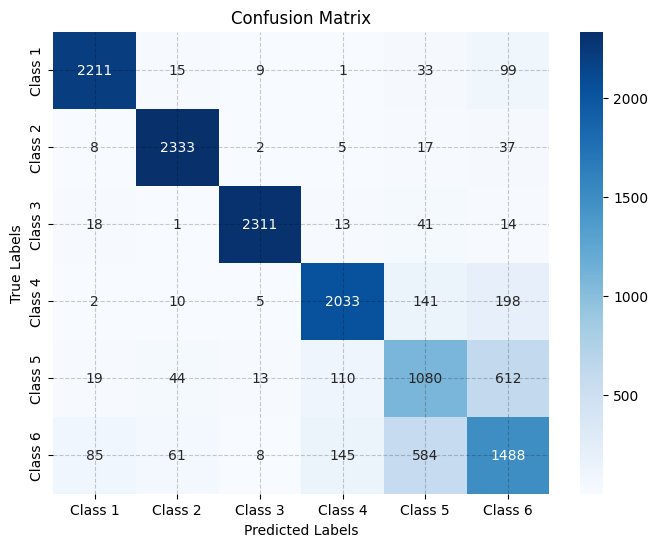

In [75]:
# predicted probabilities for each class
predicted_probabilities = model.predict(test_padded)
# probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)
# confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f'Class {i+1}' for i in range(6)], 
            yticklabels=[f'Class {i+1}' for i in range(6)])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

432/432 [==============================] - 1s 1ms/step


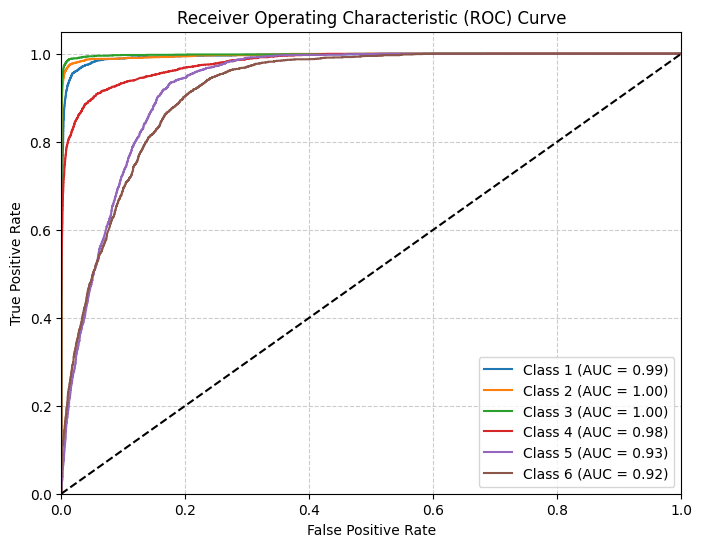

In [76]:
# predicted probabilities for each class
predicted_probabilities = model.predict(test_padded)
# ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [77]:
# predicted probabilities for each class
predicted_probabilities = model.predict(test_padded)
# probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)
# classification report
class_report = classification_report(test_labels, predicted_labels)
print("Classification Report:")
print(class_report)

432/432 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2368
           1       0.95      0.97      0.96      2402
           2       0.98      0.96      0.97      2398
           3       0.88      0.85      0.87      2389
           4       0.57      0.58      0.57      1878
           5       0.61      0.63      0.62      2371

    accuracy                           0.83     13806
   macro avg       0.82      0.82      0.82     13806
weighted avg       0.83      0.83      0.83     13806



In [78]:
# test data Series to a list
test_texts_list = test_texts.tolist()
# dictionaries to store counts for correct and incorrect predictions
correct_counts = {i: 0 for i in range(6)}
incorrect_counts = {i: 0 for i in range(6)}
for i in range(len(test_labels)):
    true_label = test_labels.iloc[i]  
    predicted_label = predicted_labels[i]
    if true_label == predicted_label:
        correct_counts[true_label] += 1
    else:
        incorrect_counts[true_label] += 1
print("Correct Predictions:")
print(tabulate([[f'Class {k+1}', v] for k, v in correct_counts.items()], headers=['Class', 'Correct Count']))
print("\nIncorrect Predictions:")
print(tabulate([[f'Class {k+1}', v] for k, v in incorrect_counts.items()], headers=['Class', 'Incorrect Count']))

Correct Predictions:
Class      Correct Count
-------  ---------------
Class 1             2211
Class 2             2333
Class 3             2311
Class 4             2033
Class 5             1080
Class 6             1488

Incorrect Predictions:
Class      Incorrect Count
-------  -----------------
Class 1                157
Class 2                 69
Class 3                 87
Class 4                356
Class 5                798
Class 6                883


### References

- [NN-SVG: Neural Network SVG Drawer](https://alexlenail.me/NN-SVG/): A tool for visualizing neural network architectures.
- [TensorFlow Keras Text Classification Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification): Tutorial on text classification using TensorFlow's Keras API.
- [TensorFlow Text Classification with RNNs Tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn): Tutorial on text classification using recurrent neural networks in TensorFlow.
